In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tqdm
import typing

import theoretical_models

_ = matplotlib.rc("text", usetex=True)
_ = matplotlib.rc("font", family="serif", serif="CMU Serif")

In [5]:
def filter_dataframe(df: pd.DataFrame, **kwargs):
    """Filter the dataframe according to the keyword arguments"""
    filtered_df = df
    for key, value in kwargs.items():
        if not isinstance(value, typing.Union[list, tuple]):
            value = [value]
        filtered_df = filtered_df[filtered_df[key].isin(value)]
    return filtered_df

# Figure 1 Proposals

In [146]:
def synth_recall(row):
    try:
        value = theoretical_models.recall.simulation(
            k=row["k"],
            n=row["n"],
            m=row["batch_size"],
            b=row["b"],
            k_b=row["k_b"],
            reps=5,
        )[0]
        return value
    except:
        return None

In [356]:
def subplot(
    ax: plt.axes,
    df: pd.DataFrame,
    x_axis: str,
    y_axis: str,
    lines: typing.Union[str, list[dict]],
    markers: typing.Union[str, list[str]] = "o",
    markersize: int = None,
    log_x: bool = False,
    log_y: bool = False,
    log_x_base: int = 2,
    log_y_base: int = 2,
    x_lim: tuple[float] = None,
    y_lim: tuple[float] = None,
    colors: list[str] = [f"C{i}" for i in range(12)],
    legend: bool = True,
    legend_fontsize: int = 14,
    legend_keys: list[str] = None,
    scatter_only: bool = False,
    xlabel: str = None,
    ylabel: str = None,
    label_fontsize: int = 16,
    **kwargs,
) -> None:
    """Plot a candidate for Figure 1 (Doug's theoretical duration vs n vs recall"""
    df = filter_dataframe(df, **kwargs).sort_values(x_axis)
    if isinstance(lines, str):
        lines = [{lines: sorted([*set(df[lines])])}]
    for line_id, line in enumerate(lines):
        color = colors[line_id]
        if legend_keys:
            label = legend_keys[line_id]
        else:
            label = "".join(f"{key} = {val}, " for key, val in line.items())[:-2]
        marker = markers if isinstance(markers, str) else markers[line_id]
        line_df = filter_dataframe(df, **line)

        # recall = line_df.apply(synth_recall, axis=1)
        # print(line, recall.mean(), recall.std())
        
        ax.scatter(line_df[x_axis], line_df[y_axis], color=color, label=label, marker=marker, s=markersize)
        if not scatter_only:
            ax.plot(line_df[x_axis], line_df[y_axis], color=color, alpha=0.4)
    if log_x:
        ax.set_xscale("log", base=log_x_base)
    if log_y:
        ax.set_yscale("log", base=log_y_base)
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    if legend:
        ax.legend(frameon=False, fontsize=legend_fontsize)
    if xlabel != "":
        ax.set_xlabel(xlabel if xlabel else x_axis, fontsize=label_fontsize)
    if ylabel != "":
        ax.set_ylabel(ylabel if ylabel else y_axis, fontsize=label_fontsize)
    sns.despine()
    return df

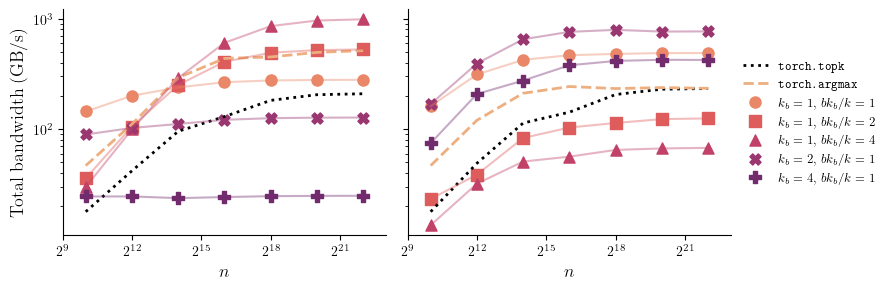

In [288]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), sharey=True)
# axes = [axes]

X_AXIS, Y_AXIS = "n", "bandwidth"#, "duration_mean"
COLOR_SCHEME = {0: "flare", 1: "blend:#FF6F79,#6FB0FF"}[0]

def bandwidth(row):
    value = dict(float32=4, float16=2)[row["dtype"]]
    value *= row["n"] + row["k"]
    value *= row["batch_size"]
    value /= row["duration_mean"] / row["n_inner"]
    return value / 1e9


benchmark_df = pd.read_json("../data/synth-data-merged-v2.jsonl", lines=True)

benchmark_df.loc[:, "bandwidth"] = benchmark_df.apply(bandwidth, axis=1)

def plot_line(ax, method, method_id, color, **kwargs):
    label = r"$\texttt{torch.argmax}$" if method_id else r"$\texttt{torch.topk}$"
    # label = r"$\texttt{torch.argmax}$ (recall = $0.64$)" if method_id else r"Default (recall = $1.00$)"
    linestyle = "dashed" if method_id else "dotted"
    kwarg = {"compile": None} if method_id else {}
    default_df = filter_dataframe(
        benchmark_df, 
        method=method,
        batch_size=256,
        **kwarg,
        **kwargs,
    ).sort_values(X_AXIS)
    ax.plot(default_df[X_AXIS], default_df[Y_AXIS], color=color, label=label, linewidth=2, linestyle=linestyle)


palette = sns.color_palette(COLOR_SCHEME, as_cmap=True)
plot_line(axes[0], "approx_topk.torch_default.topk", 0, "k", k=256)
plot_line(axes[0], "approx_topk.bucket_argmax.topk_torch", 1, palette(1), k=256)


subplot(
    ax=axes[0],
    df=benchmark_df,
    x_axis=X_AXIS,
    y_axis=Y_AXIS,
    lines=[
        {"k_b": 1, "k_mult": 1},
        {"k_b": 1, "k_mult": 2},
        {"k_b": 1, "k_mult": 4},
        {"k_b": 2, "k_mult": 1},
        {"k_b": 4, "k_mult": 1},
    ],
    markers=["o", "s", "^", "X", "P", "D", "v"],
    markersize=64,
    log_x=True,
    log_y=True,
    log_y_base=10,
    legend=False,
    colors=[palette((1 + i) / 6) for i in range(5)],
    xlabel=r"$n$",
    ylabel="Total bandwidth (GB/s)",
    x_lim=(2 ** 9, 2 ** 23),
    label_fontsize=13,
    batch_size=256,
    k=64,
    k_b=[1,2,4],
    k_mult=[1,2,4],
    method="approx_topk.priority_queue.topk",
    compile=None,
)



plot_line(axes[1], "approx_topk.torch_default.topk", 0, "k", n_over_k=4)
plot_line(axes[1], "approx_topk.bucket_argmax.topk_torch", 1, palette(1), n_over_k=4)

subplot(
    ax=axes[1],
    df=benchmark_df,
    x_axis=X_AXIS,
    y_axis=Y_AXIS,
    lines=[
        {"k_b": 1, "k_mult": 1},
        {"k_b": 1, "k_mult": 2},
        {"k_b": 1, "k_mult": 4},
        {"k_b": 2, "k_mult": 1},
        {"k_b": 4, "k_mult": 1},
    ],
    # legend_keys=[
    #     r"$k_b = 1$, $bk_b / k = 1$ (recall = $0.64$)",
    #     r"$k_b = 1$, $bk_b / k = 2$ (recall = $0.79$)",
    #     r"$k_b = 1$, $bk_b / k = 4$ (recall = $0.89$)",
    #     r"$k_b = 2$, $bk_b / k = 1$ (recall = $0.73$)",
    #     r"$k_b = 4$, $bk_b / k = 1$ (recall = $0.81$)",
    # ],
    legend_keys=[
        r"$k_b = 1$, $bk_b / k = 1$",
        r"$k_b = 1$, $bk_b / k = 2$",
        r"$k_b = 1$, $bk_b / k = 4$",
        r"$k_b = 2$, $bk_b / k = 1$",
        r"$k_b = 4$, $bk_b / k = 1$",
    ],
    markers=["o", "s", "^", "X", "P", "D", "v"],
    markersize=64,
    log_x=True,
    log_y=True,
    log_y_base=10,
    legend=False,
    colors=[palette((1 + i) / 6) for i in range(5)],
    xlabel=r"$n$",
    ylabel="",
    label_fontsize=13,
    x_lim=(2 ** 9, 2 ** 23),
    batch_size=256,
    n_over_k=4,
    k_b=[1,2,4],
    k_mult=[1,2,4],
    method="approx_topk.priority_queue.topk",
    compile=None,
)


# test = benchmark_df
# # test = test[test.n_over_k == 4]
# # test = test[test.k_b == 1]
# # test = test[test.k_mult == 4]
# print(len(test))
# print(test)


_ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout()
plt.savefig("figures/figure-01-bandwidth.pdf")


# SparQ Tradeoff Curve

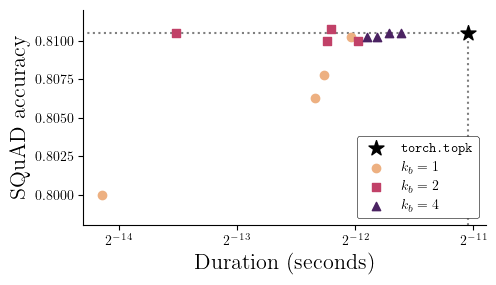

In [378]:
sparq_df = pd.read_json("../data/sparq-data-merged.jsonl", lines=True)
exact_df = pd.read_json("../data/sparq-data-exact-merged.jsonl", lines=True)
sparq_df = pd.concat([sparq_df, exact_df])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
if not isinstance(axes, typing.Iterable):
    axes = [axes]


for n, ax in zip([1409, 1659], axes):
    
    task = {1409: "SQuAD", 1659: "Repetition"}[n]
    y_lim = {1409: (0.798, 0.812), 1659: (165, 215)}[n]

    exact_df = sparq_df
    exact_df = exact_df[exact_df.n == n]
    exact_df = exact_df[exact_df.exact_topk == True]
    exact_df = exact_df[exact_df.compile.isin([None])]

    duration, score = exact_df.duration_mean.mean(), exact_df.score.mean()
    ax.scatter(duration, score, color="k", marker="*", s=128, label=r"$\texttt{torch.topk}$")
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5}
    ax.plot([duration, duration], [0, score], **plot_kwargs)
    ax.plot([0, duration], [score, score], **plot_kwargs)

    subplot(
        ax=ax,
        df=sparq_df,
        x_axis="duration_mean",
        y_axis="score",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
        ],
        markers=["o", "s", "^"],
        scatter_only=True,
        xlabel="Duration (seconds)",
        ylabel="SQuAD accuracy" if n == 1409 else "Repetition match",
        log_x=True,
        y_lim=y_lim,
        legend=False,
        n=n,
        method="approx_topk.priority_queue.topk",
        interleaved=True,
        colors=[palette(i / 2) for i in range(3)],
    )

legend = axes[len(axes) - 1].legend(fontsize=10, loc=4, framealpha=1)
legend.get_frame().set_linewidth(0.4)
legend.get_frame().set_edgecolor("k")
plt.tight_layout()
plt.savefig("figures/figure-02-sparq-tradeoff-squad.pdf")

# Knowledge Graph Completion Tradeoff Curve

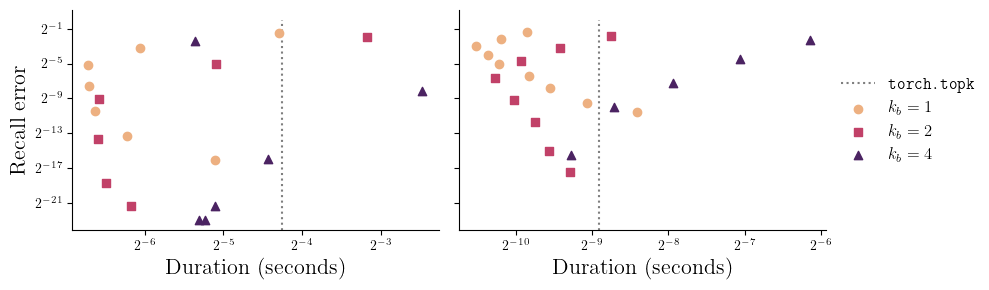

In [477]:
graph_df = pd.read_json("../data/graph-data-merged.jsonl", lines=True)
graph_exact_df = pd.read_json("../data/graph-data-exact-merged.jsonl", lines=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]


k, batch_size = 100, 128

duration = graph_exact_df[(graph_exact_df.k == k) & (graph_exact_df.batch_size == batch_size)].duration_mean.mean()
plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5}
axes[0].plot([duration, duration], [0, 1], **plot_kwargs)

t = subplot(
    ax=axes[0],
    df=graph_df,
    x_axis="duration_mean",
    y_axis="error",
    lines=[
        {"k_b": 1}, 
        {"k_b": 2}, 
        {"k_b": 4},
    ],
    legend_keys=[
        r"$k_b = 1$",
        r"$k_b = 2$",
        r"$k_b = 4$",
    ],
    markers=["o", "s", "^"],
    scatter_only=True,
    xlabel="Duration (seconds)",
    ylabel="Recall error",
    log_x=True,
    log_y=True,
    legend=False,
    k=k,
    batch_size=batch_size,
    method="approx_topk.priority_queue.topk",
    interleaved=True,
    colors=[palette(i / 2) for i in range(3)],
)


k, batch_size = 256, 64

vocab_df = pd.read_json("../data/vocab-data-merged-compressed.jsonl", lines=True)
vocab_exact_df = pd.read_json("../data/vocab-data-exact-merged.jsonl", lines=True)

duration = vocab_exact_df[(vocab_exact_df.k == k) & (vocab_exact_df.batch_size == batch_size)].duration_mean.mean()
plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"$\texttt{torch.topk}$"}
axes[1].plot([duration, duration], [0, 1], **plot_kwargs)

t = subplot(
    ax=axes[1],
    df=vocab_df,
    x_axis="duration_mean",
    y_axis="error",
    lines=[
        {"k_b": 1}, 
        {"k_b": 2}, 
        {"k_b": 4},
    ],
    legend_keys=[
        r"$k_b = 1$",
        r"$k_b = 2$",
        r"$k_b = 4$",
    ],
    markers=["o", "s", "^"],
    scatter_only=True,
    xlabel="Duration (seconds)",
    ylabel="",
    log_x=True,
    log_y=True,
    legend=False,
    k=k,
    batch_size=batch_size,
    colors=[palette(i / 2) for i in range(3)],
)


# legend = axes[len(axes) - 1].legend(fontsize=10, loc=4, framealpha=1)
# legend.get_frame().set_linewidth(0.4)
# legend.get_frame().set_edgecolor("k")
_ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()
plt.savefig("figures/figure-04-kgc-and-vocab-tradeoff.pdf")


# Theoretical results

In [445]:
SMALL_K = 256
LARGE_K = 1048576

# def simulated_recall(row):
#     result = theoretical_models.recall.simulation(
#         k=row["k"],
#         n=row["n"],
#         b=row["b"],
#         k_b=row["k_b"],
#         m=row["batch_size"],
#         reps=25,
#     )
#     # print(row["k"], row["n"], row["b"], row["k_b"], row["batch_size"], result[0])
#     return result[0]


# def simulated_error(row):
#     return 1 - row["recall"]


# synth_df = pd.read_json("../data/synth-data-merged-v2.jsonl", lines=True)
# synth_df = synth_df[synth_df.k.isin([SMALL_K, LARGE_K])]
# synth_df.loc[:, "recall"] = synth_df.apply(simulated_recall, axis=1)
# synth_df.loc[:, "error"] = synth_df.apply(simulated_error, axis=1)


# for feature in ["k", "n", "batch_size", "k_mult"]:
#     print(f"{feature}:", [*set(synth_df[feature])])

k: [256, 1048576]
n: [1024, 4096, 262144, 16384, 65536, 1048576, 4194304]
batch_size: [256, 1]
k_mult: [32, 1, 2, 4, 8, 16]


/tmp/ipykernel_1283293/1626985408.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)


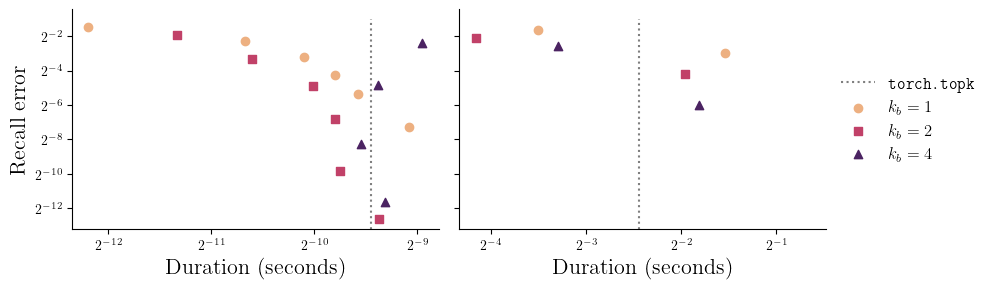

In [476]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]


exact_df = synth_df
exact_df = exact_df[exact_df.k == exact_df.k_b]

for ax, k in zip(axes, [SMALL_K, LARGE_K]):

    ylabel = "Recall error" if k == SMALL_K else ""
    n = 16384 if k == SMALL_K else 4194304
    batch_size = 256

    duration = exact_df[(exact_df.k == k) & (exact_df.n == n) & (exact_df.batch_size == batch_size)].duration_mean.mean()
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"$\texttt{torch.topk}$"}
    ax.plot([duration, duration], [0, 0.5], **plot_kwargs)


    subdf = subplot(
        ax=ax,
        df=synth_df,
        x_axis="duration_mean",
        y_axis="error",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
        ],
        markers=["o", "s", "^"],
        scatter_only=True,
        xlabel="Duration (seconds)",
        ylabel=ylabel,
        log_x=True,
        log_y=True,
        legend=False,
        k=k,
        n=n,
        batch_size=batch_size,
        method="approx_topk.priority_queue.topk",
        colors=[palette(i / 2) for i in range(3)],
    )

    _ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.savefig("figures/figure-03-theoretical-tradeoff.pdf")



In [458]:
colors = sns.color_palette("flare", n_colors=11).as_hex()

for id, color in enumerate(colors):
    str_id = f"0{id + 1}"[-2:]
    str_color = color[1:].upper()
    line = "\definecolor{p" + str_id + "}{HTML}{" + str_color + "}"
    print(line)


\definecolor{p01}{HTML}{EB9B74}
\definecolor{p02}{HTML}{E98768}
\definecolor{p03}{HTML}{E5715E}
\definecolor{p04}{HTML}{DE5D5C}
\definecolor{p05}{HTML}{D34C60}
\definecolor{p06}{HTML}{C14168}
\definecolor{p07}{HTML}{AE3B6D}
\definecolor{p08}{HTML}{9A3670}
\definecolor{p09}{HTML}{863071}
\definecolor{p10}{HTML}{722C6E}
\definecolor{p11}{HTML}{5E2868}
